In [28]:
import pandas as pd
%run mirazul_ploting_utils_changed.ipynb
%run confusion_matrix_pretty_print.ipynb

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import *
import numpy as np

import pickle 
from xgboost import XGBClassifier


from sklearn.ensemble import RandomForestClassifier


from sklearn.ensemble import GradientBoostingClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

import lightgbm as lgb

# Importing KNN
from sklearn.neighbors import KNeighborsClassifier


from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.naive_bayes import GaussianNB
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('train.csv')
df.replace(to_replace=' ', value=np.nan, inplace=True)

df1 = pd.read_csv('test.csv')
df1.replace(to_replace=' ', value=np.nan, inplace=True)

df.rename(columns={
    'INTUBADO': 'INTUBATED',
    'ASMA': 'ASTHMA',
    'HIPERTENSION': 'HYPERTENSION',
    'Age': 'AGE',
    'Sex': 'SEX'
},
          inplace=True)
df1.rename(columns={
    'INTUBADO': 'INTUBATED',
    'ASMA': 'ASTHMA',
    'HIPERTENSION': 'HYPERTENSION',
    'Age': 'AGE',
    'Sex': 'SEX'
},
           inplace=True)
x_train = df.drop(columns=['ICU'])
y_train = df['ICU']
x_test = df1.drop(columns=['ICU'])
y_test = df1['ICU']

X_train=  x_train
X_test = x_test

In [4]:
from joblib import dump
from joblib import load



HGSOXGB_clf = load('HGSOXGB_clf.joblib')

RF = load('RF.joblib')

GBC = load('GBC.joblib')
LR = load('LR.joblib')
LDA_clf = load('LDA_clf.joblib')
GNB_clf = load('GNB_clf.joblib')
KNN_clf = load('KNN_clf.joblib')
LGBM = load('LGBM.joblib')



In [5]:
proba_dic=dict(
    HGSOXGB= HGSOXGB_clf.predict_proba(x_test)[:,1],
    GBC=GBC.predict_proba(x_test)[:,1], 
    LDA=LDA_clf.predict_proba(x_test)[:,1],
    KNN=KNN_clf.predict_proba(x_test)[:,1],
    RF=RF.predict_proba(x_test)[:,1],
    LGBM=LGBM.predict_proba(x_test)[:,1],
    GNB=GNB_clf.predict_proba(x_test)[:,1],
    LR=LR.predict_proba(x_test)[:,1]
   
    )

In [6]:
proba_dic=dict(
    HGSOXGB= HGSOXGB_clf.predict_proba(x_test)[:,1],
    GNB=GNB_clf.predict_proba(x_test)[:,1],
    LDA=LDA_clf.predict_proba(x_test)[:,1],
    KNN=KNN_clf.predict_proba(x_test)[:,1],
    RF=RF.predict_proba(x_test)[:,1],
    LGBM=LGBM.predict_proba(x_test)[:,1],
    GBC=GBC.predict_proba(x_test)[:,1],
    LR=LR.predict_proba(x_test)[:,1]
   
    )

In [ ]:
plot_multi_precison_vs_recall_curve(proba_dic, y_test,'Precision_Recall_Curve_fresh_new.png')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


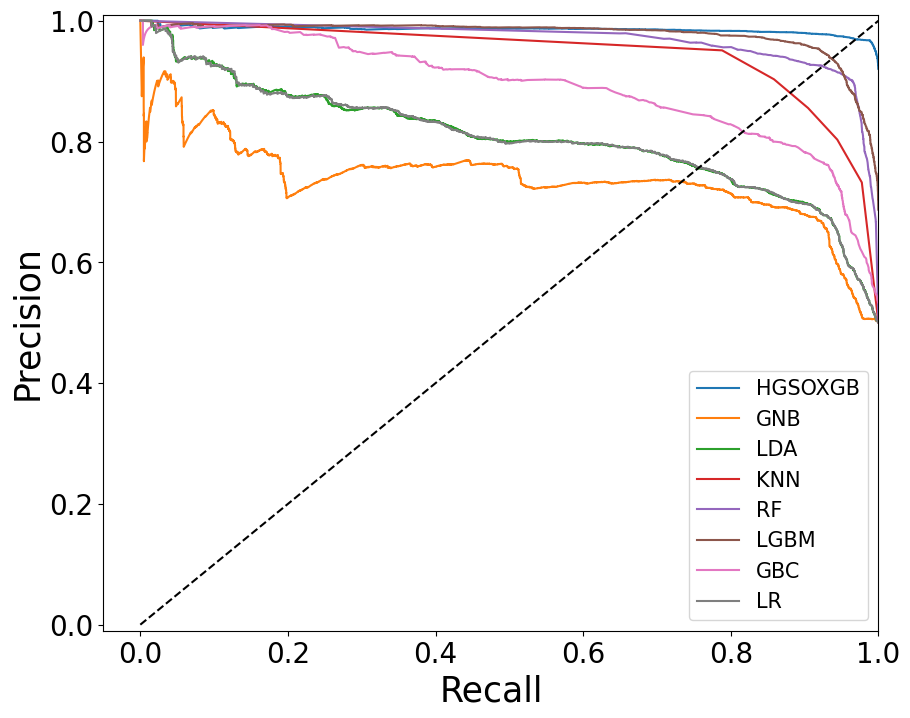

In [7]:
plot_multi_precison_vs_recall_curve(proba_dic, y_test,'Precision_Recall_Curve_fresh_new.eps')

In [8]:
x_train_new = x_train
y_train_new = y_train
x_test_new = x_test
y_test_new = y_test


from sklearn.model_selection import cross_val_score

xgb_pred = HGSOXGB_clf.predict(x_test_new)

In [9]:
accuracy_score(y_test_new, xgb_pred)

0.9762679284341269

In [11]:


def est(clf, names):
    estm = []
    for i in range(len(clf)):
        n = names[i]
        claf = clf[i]
        estm.append((n, claf))
    return estm


clf = [HGSOXGB_clf, GNB_clf, LDA_clf, KNN_clf, RF, LGBM, GBC, LR]
name = ['HGSOXGB', 'GNB', 'LDA', 'KNN', 'RF', 'LGBM', 'GBC', 'LR']
est_1 = est(clf, name)
cross_val_scores = {}
accuracy_scores = {}
error_scores = {}
f1_scores = {}
fpr_scores = {}
kappa_scores = {}
mcc_scores = {}
ppv_scores = {}
sensitivity_scores = {}
specificity_scores = {}
auc_scores = {}
y_preds = {}
y_probs = {}
threat_scores = {}
balanced_accuracy_scores = {}

for algorithm, model in est_1:
    y_pred = model.predict(x_test_new)
    y_prob = model.predict_proba(x_test_new)
    y_preds[algorithm] = y_pred
    y_probs[algorithm] = y_prob

    cross_val_scores[algorithm] = cross_val_score(model,
                                                  x_train_new,
                                                  y_train_new,
                                                  cv=10).mean()
    accuracy_scores[algorithm] = accuracy_score(y_test_new, y_pred)
    error_scores[algorithm] = 1 - accuracy_scores[algorithm]
    f1_scores[algorithm] = f1_score(y_test_new, y_pred, average="weighted")
    kappa_scores[algorithm] = cohen_kappa_score(y_test_new, y_pred)
    mcc_scores[algorithm] = matthews_corrcoef(y_test_new, y_pred)
    ppv_scores[algorithm] = precision_score(y_test_new,
                                            y_pred,
                                            average="weighted")
    sensitivity_scores[algorithm] = recall_score(y_test_new,
                                                 y_pred,
                                                 average="weighted")
    confusion_matrix_ = confusion_matrix(y_test_new, y_pred)
    FP = confusion_matrix_.sum(axis=0) - np.diag(confusion_matrix_)
    FN = confusion_matrix_.sum(axis=1) - np.diag(confusion_matrix_)
    TP = np.diag(confusion_matrix_)
    TN = confusion_matrix_.sum() - (FP + FN + TP)
    fpr_scores[algorithm] = (FP / (FP + TN)).mean()
    specificity_scores[algorithm] = (TN / (TN + FP)).mean()
    threat_scores[algorithm] = (TP / (TP + FN + FP)).mean()
    balanced_accuracy_scores[algorithm] = (
        (sensitivity_scores[algorithm] + specificity_scores[algorithm]) /
        2).mean()
    print('done for one')

done for one
done for one
done for one
done for one
done for one
[LightGBM] [Info] Number of positive: 12353, number of negative: 12361
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002652 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2670
[LightGBM] [Info] Number of data points in the train set: 24714, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499838 -> initscore=-0.000647
[LightGBM] [Info] Start training from score -0.000647
[LightGBM] [Info] Number of positive: 12353, number of negative: 12361
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2665
[LightGBM] [Info] Number of data points in the train set: 24714, number of used features: 15
[LightGBM] 

In [12]:
performance_metrics = {
    'Cross_val_scores': cross_val_scores,
    'Accuracy_scores': accuracy_scores,
    'Error_scores': error_scores,
    'F1_scores': f1_scores,
    'FPR_scores': fpr_scores,
    'Kappa_scores': kappa_scores,
    'MCC_scores': mcc_scores,
    'PPV_scores': ppv_scores,
    'Sensitivity_scores': sensitivity_scores,
    'Specificity_scores': specificity_scores,
    'Threat_scores': threat_scores,
    'Balanced_accuracy_scores': balanced_accuracy_scores
}

perfo_m = pd.DataFrame(performance_metrics)
perfo_m.to_csv('performance_metrics_final_fresh_1.csv')
perfo_m

,Cross_val_scores,Accuracy_scores,Error_scores,F1_scores,FPR_scores,Kappa_scores,MCC_scores,PPV_scores,Sensitivity_scores,Specificity_scores,Threat_scores,Balanced_accuracy_scores
HGSOXGB,0.975382,0.976268,0.023732,0.976266,0.023739,0.952535,0.952693,0.976425,0.976268,0.976261,0.953632,0.976265
GNB,0.671377,0.664202,0.335798,0.656628,0.335688,0.328552,0.344160,0.680255,0.664202,0.664312,0.490971,0.664257
LDA,0.759068,0.754399,0.245601,0.750629,0.245692,0.508709,0.524727,0.770625,0.754399,0.754308,0.601747,0.754354
KNN,0.877531,0.875869,0.124131,0.875763,0.124153,0.751727,0.752973,0.877111,0.875869,0.875847,0.778999,0.875858
RF,0.926985,0.929026,0.070974,0.928955,0.070998,0.858045,0.859720,0.930699,0.929026,0.929002,0.867340,0.929014
LGBM,0.938820,0.936641,0.063359,0.936639,0.063363,0.873280,0.873318,0.936678,0.936641,0.936637,0.880828,0.936639
GBC,0.825419,0.824634,0.175366,0.823637,0.175421,0.649229,0.656624,0.832051,0.824634,0.824579,0.700359,0.824606
LR,0.758485,0.755878,0.244122,0.754634,0.244175,0.511704,0.516917,0.761092,0.755878,0.755825,0.606256,0.755851


In [13]:
df_pred3=pd.DataFrame(proba_dic)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


HGSOXGB
  AUC: 0.991
GNB
  AUC: 0.783
LDA
  AUC: 0.828
KNN
  AUC: 0.941
RF
  AUC: 0.97
LGBM
  AUC: 0.981
GBC
  AUC: 0.898
LR
  AUC: 0.828


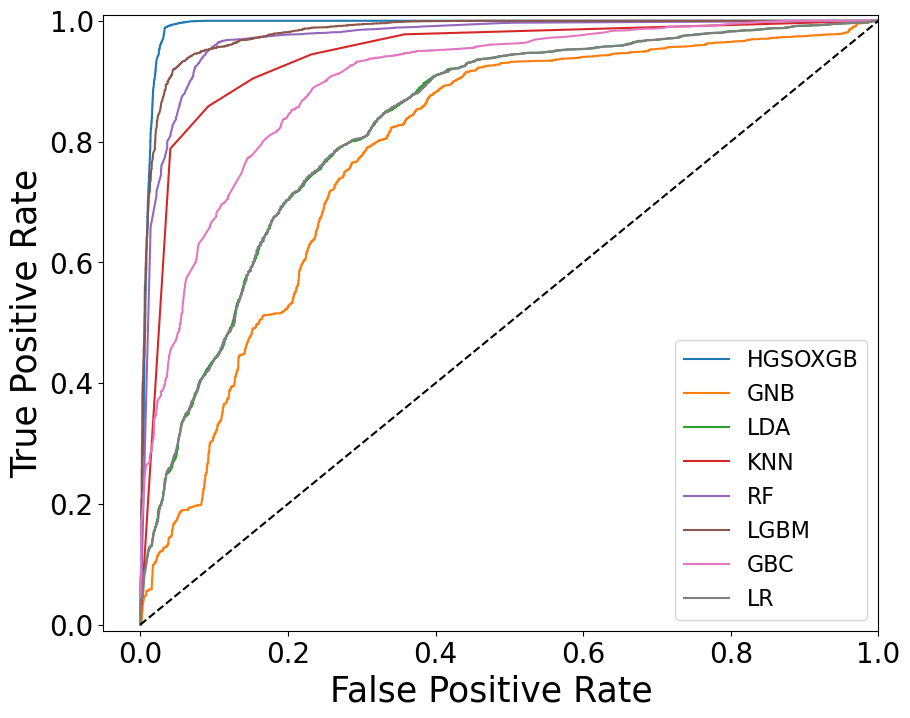

In [14]:
filename = 'ROC_curve__final_fresh.eps'
plot_roc_curves(df_pred3, y_test, filename)
#filename = 'ROC_curve__final_fresh.png'
#plot_roc_curves(df_pred3, y_test, filename)

In [17]:
df_main = pd.concat([df, df1], axis=0)
x = df_main.drop(columns=['ICU'])
y = df_main['ICU']

res_df1 = dict(HGSOXGB=cross_val_score(HGSOXGB_clf, x, y, cv=10),
               GNB=cross_val_score(GNB_clf, x, y, cv=10),
               LDA=cross_val_score(LDA_clf, x, y, cv=10),
               KNN=cross_val_score(KNN_clf, x, y, cv=10),
               RF=cross_val_score(RF, x, y, cv=10),
               LGBM=cross_val_score(LGBM, x, y, cv=10),
               GBC=cross_val_score(GBC, x, y, cv=10),
               LR=cross_val_score(LR, x, y, cv=10))

[LightGBM] [Info] Number of positive: 18444, number of negative: 18443
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002837 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3444
[LightGBM] [Info] Number of data points in the train set: 36887, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500014 -> initscore=0.000054
[LightGBM] [Info] Start training from score 0.000054
[LightGBM] [Info] Number of positive: 18444, number of negative: 18443
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002783 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3444
[LightGBM] [Info] Number of data points in the train set: 36887, number of used features: 15
[LightGBM] [In

In [18]:
res_df3 = pd.DataFrame(res_df1)
res_df3

,HGSOXGB,GNB,LDA,KNN,RF,LGBM,GBC,LR
0,0.975848,0.661625,0.757014,0.891681,0.937546,0.937058,0.822396,0.759210
1,0.980483,0.664796,0.758234,0.899000,0.947060,0.938766,0.822396,0.754818
2,0.978287,0.664064,0.750671,0.889729,0.939741,0.933154,0.818248,0.748231
3,0.978043,0.677726,0.765309,0.906319,0.946084,0.943889,0.834350,0.765065
4,0.974872,0.682849,0.768236,0.899000,0.940717,0.942913,0.835082,0.769456
5,0.975604,0.657477,0.750427,0.891925,0.935594,0.934130,0.815077,0.745304
6,0.980234,0.684236,0.766471,0.898731,0.949000,0.945827,0.838946,0.773060
7,0.974866,0.662274,0.739873,0.890678,0.938507,0.937531,0.815276,0.750122
8,0.979258,0.672035,0.750854,0.889946,0.938995,0.938995,0.811859,0.753294
9,0.977062,0.653734,0.765739,0.892387,0.939727,0.941923,0.835286,0.762323


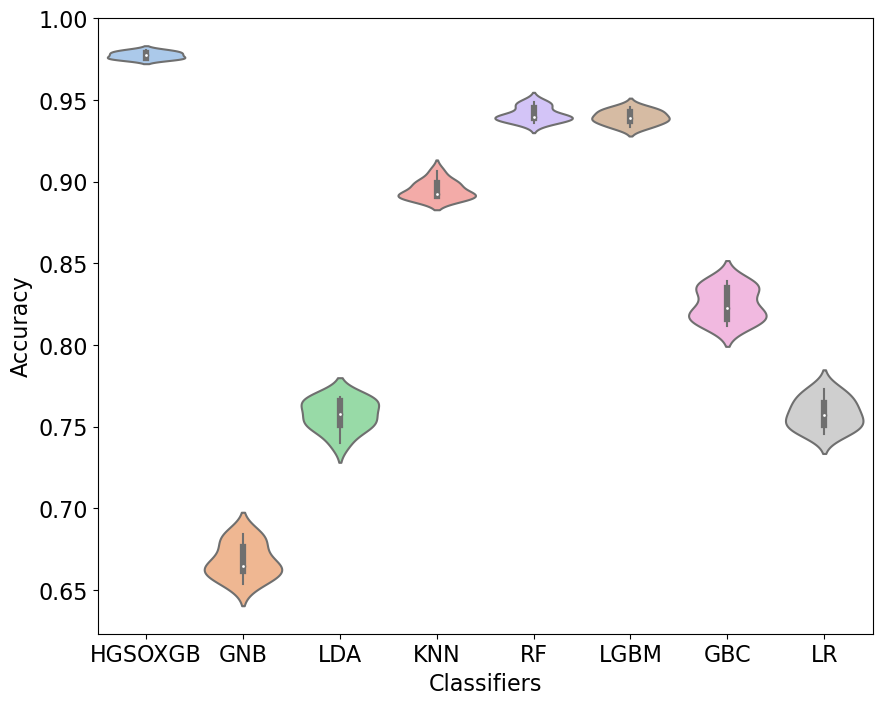

In [19]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)
ax.set_xlabel('Classifiers', fontsize=16)
ax.set_ylabel('Accuracy', fontsize=16)
sns.violinplot(ax=ax,
               data=res_df3.iloc[:, 0:8],
               palette='pastel',
               scale='width')
plt.savefig('violin_plot_fresh.eps', dpi=600)
#plt.savefig('violin_plot_fresh.png', dpi=600)

In [20]:
proba_R_D_curve = dict(HGSOXGB=HGSOXGB_clf.predict_proba(x_test),
                       GNB=GNB_clf.predict_proba(x_test),
                       LDA=LDA_clf.predict_proba(x_test),
                       KNN=KNN_clf.predict_proba(x_test),
                       RF=RF.predict_proba(x_test),
                       LGBM=LGBM.predict_proba(x_test),
                       GBC=GBC.predict_proba(x_test),
                       LR=LR.predict_proba(x_test))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


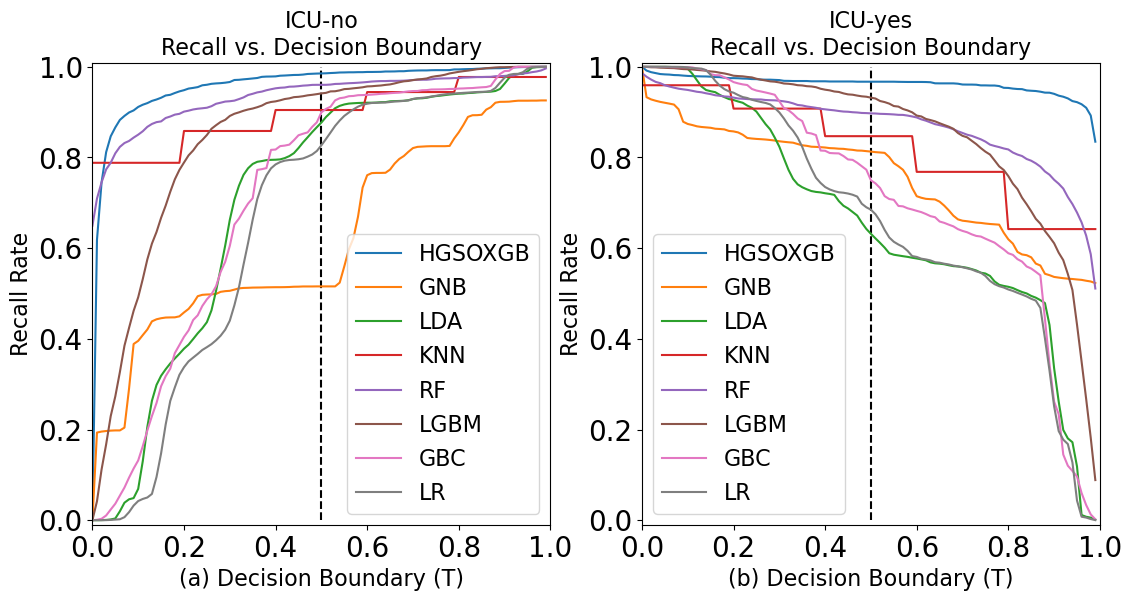

In [21]:
filename = 'multi_recall_vs_decision_boundary.eps'
plot_multi_recall_vs_decision_boundary(proba_R_D_curve, y_test, filename)

#filename = 'multi_recall_vs_decision_boundary.png'
#plot_multi_recall_vs_decision_boundary(proba_R_D_curve, y_test, filename)

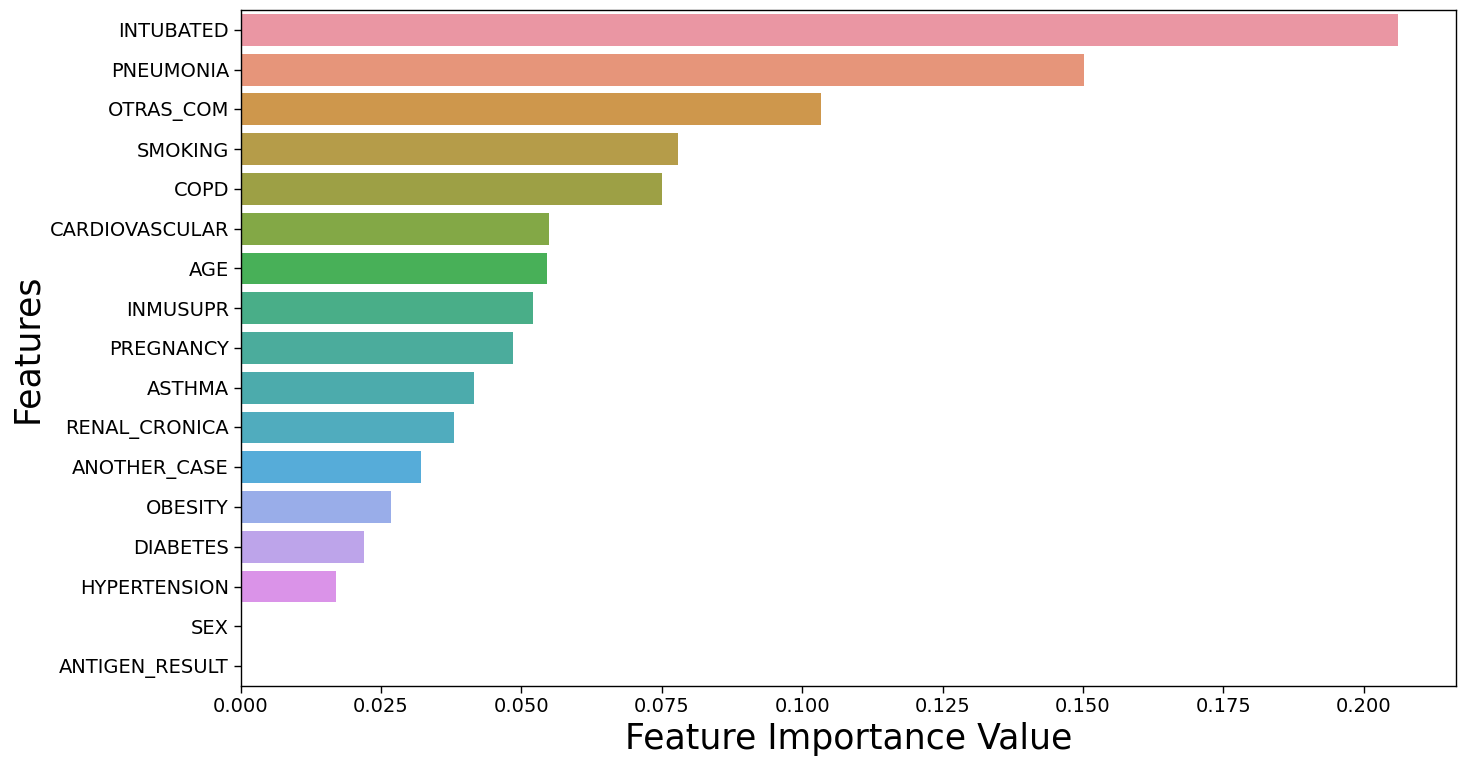

In [22]:
sns.set_context("paper",
                rc={
                    "font.size": 18,
                    "axes.titlesize": 20,
                    "axes.labelsize": 20
                })

import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams.update({'font.size': 18})

feature_imp = pd.DataFrame(sorted(
    zip(HGSOXGB_clf.feature_importances_, x_test.columns)),
                           columns=['Feature Importance Value', 'Features'])
params = {'axes.labelsize': 25}
plt.rcParams.update(params)
fig, ax = plt.subplots(figsize=(15, 8))

ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=15)
sns.barplot(x="Feature Importance Value",
            y="Features",
            data=feature_imp.sort_values(by="Feature Importance Value",
                                         ascending=False))

plt.tight_layout()

plt.savefig('icu_importances_fresh.eps', dpi=600)
#plt.savefig('icu_importances_fresh.png', dpi=600)
plt.show()

In [ ]:
from pycm import *

In [23]:
df_performance = pd.read_csv('performance_metrics_final_fresh_1.csv')
df_performance1 = df_performance.T
df_performance1

,0,1,2,3,4,5,6,7
Unnamed: 0,HGSOXGB,GNB,LDA,KNN,RF,LGBM,GBC,LR
Cross_val_scores,0.975382,0.671377,0.759068,0.877531,0.926985,0.93882,0.825419,0.758485
Accuracy_scores,0.976268,0.664202,0.754399,0.875869,0.929026,0.936641,0.824634,0.755878
Error_scores,0.023732,0.335798,0.245601,0.124131,0.070974,0.063359,0.175366,0.244122
F1_scores,0.976266,0.656628,0.750629,0.875763,0.928955,0.936639,0.823637,0.754634
FPR_scores,0.023739,0.335688,0.245692,0.124153,0.070998,0.063363,0.175421,0.244175
Kappa_scores,0.952535,0.328552,0.508709,0.751727,0.858045,0.87328,0.649229,0.511704
MCC_scores,0.952693,0.34416,0.524727,0.752973,0.85972,0.873318,0.656624,0.516917
PPV_scores,0.976425,0.680255,0.770625,0.877111,0.930699,0.936678,0.832051,0.761092
Sensitivity_scores,0.976268,0.664202,0.754399,0.875869,0.929026,0.936641,0.824634,0.755878


In [24]:
df_performance1 = df_performance1.rename(columns=df_performance1.iloc[0]).drop(
    df_performance1.index[0])

In [25]:
df_performance1.drop(index=[
    'Cross_val_scores', 'Error_scores', 'FPR_scores', 'PPV_scores',
    'Specificity_scores', 'Threat_scores', 'Balanced_accuracy_scores'
],
                     inplace=True)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


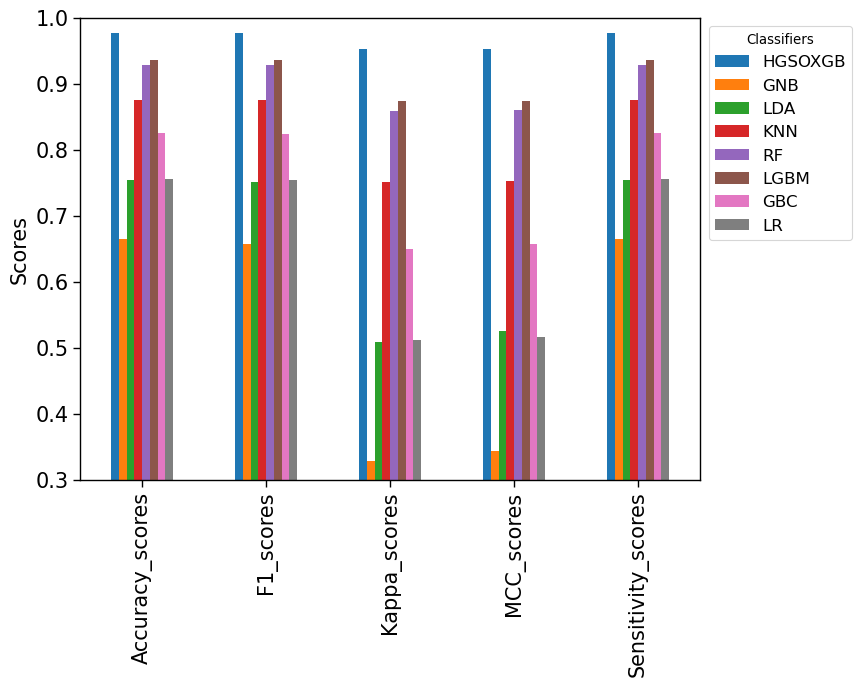

In [26]:
from matplotlib.font_manager import FontProperties

fontP = FontProperties()
fontP.set_size('xx-small')
df_performance1.plot.bar(figsize=[8, 6], rot=90)
plt.ylim(.3, 1)
plt.ylabel('Scores', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(title='Classifiers',
           bbox_to_anchor=(1, 1),
           loc='upper left',
           fontsize=12)
plt.savefig('performance.eps', bbox_inches='tight', dpi=600)
#plt.savefig('performance.png', bbox_inches='tight', dpi=600)

In [27]:
X_train1 = x_train.reset_index(drop=True)
y_train1 = y_train.reset_index(drop=True)
X_test1 = x_test.reset_index(drop=True)
y_test1 = y_test.reset_index(drop=True)

results_org = bootstrap_model(
    HGSOXGB_clf,
    X_train1,
    y_train1,
    X_test1,
    y_test1,
    100,  # change the number of bootstraps here
    0.5)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


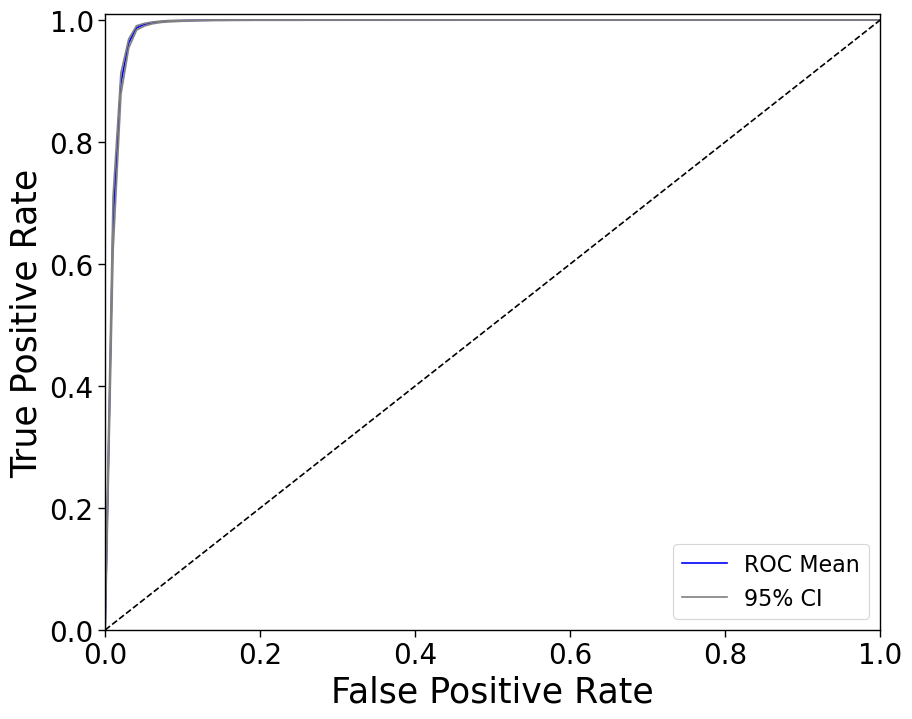

In [29]:
total_auc_org = []
for r in results_org['fpr_tpr']:
    total_auc_org.append(auc(r[0], r[1]))
total_auc_org
df_interp_org = pd.DataFrame(roc_interp(results_org['fpr_tpr'])).T
m_org = df_interp_org.mean(axis=1).values.tolist()
ci_org = df_interp_org.quantile([.025, .975], axis=1).values.tolist()

filename_bootstrap_org = 'Bootstrap_ROC_ICU_fresh.eps'
plot_bootstrap_roc(m_org, ci_org, filename_bootstrap_org)

#filename_bootstrap_org = 'Bootstrap_ROC_ICU_fresh.png'
#plot_bootstrap_roc(m_org, ci_org, filename_bootstrap_org)

In [30]:

y_pred_gnb = GNB_clf.predict(x_test)
y_pred_lda = LDA_clf.predict(x_test)
y_pred_knn = KNN_clf.predict(x_test)
y_pred_lgbm = LGBM.predict(x_test)
y_pred_gbc = GBC.predict(x_test)
y_pred_lr = LR.predict(x_test)

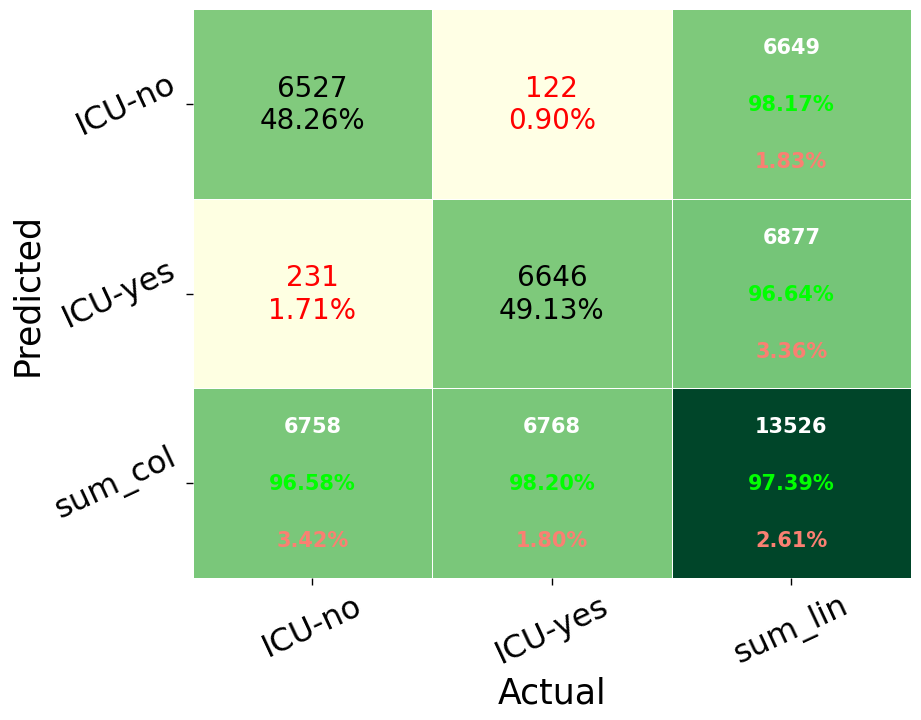

In [31]:
%run confusion_matrix_pretty_print.ipynb
y_pred_hgsoxgb = HGSOXGB_clf.predict(x_test_new)
plot_confusion_matrix_from_data(y_test,
                                y_pred_hgsoxgb,
                                columns=['ICU-no', 'ICU-yes'],
                                fz=20,
                                filename='ICU_HGSOXGB_CM.eps',
                                figsize=[10, 8])

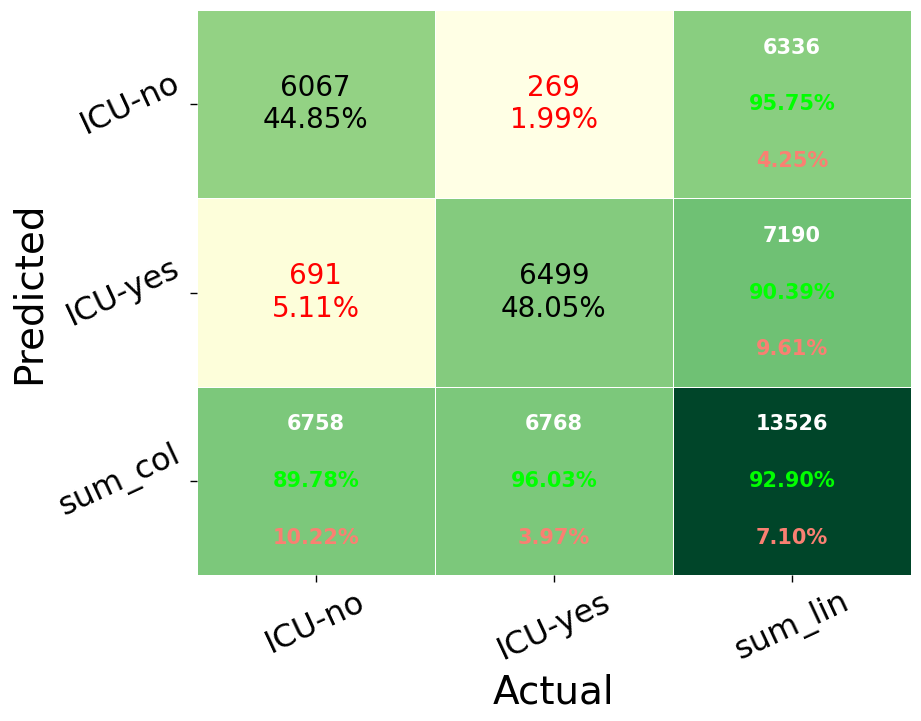

In [32]:
y_pred_rf = RF.predict(x_test_new)
plot_confusion_matrix_from_data(y_test,
                                y_pred_rf,
                                columns=['ICU-no', 'ICU-yes'],
                                fz=20,
                                filename='ICU_RF_CM.eps',
                                figsize=[10, 8])

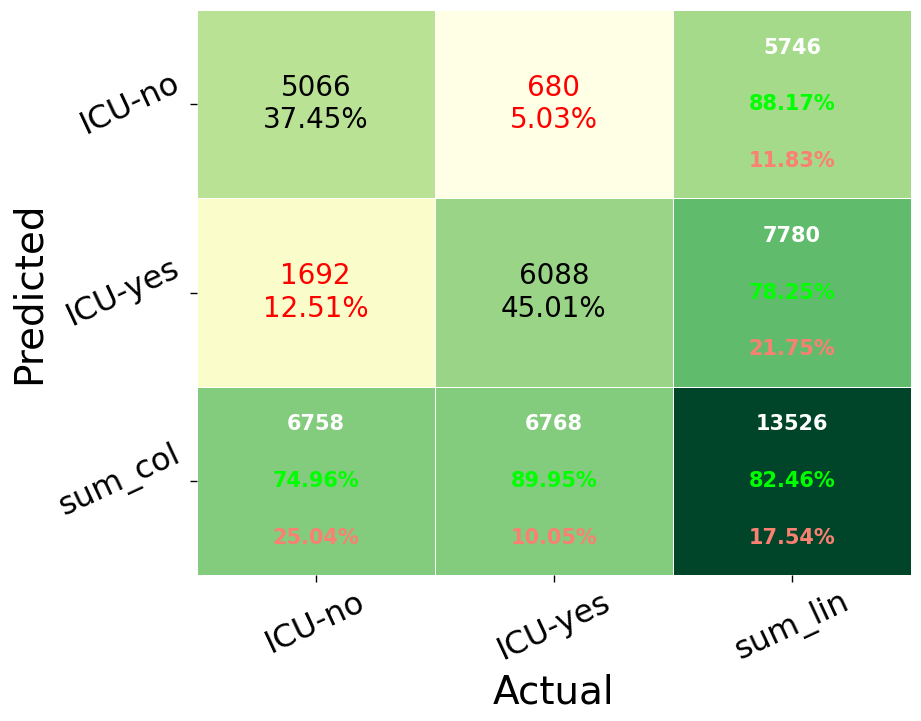

In [33]:
plot_confusion_matrix_from_data(y_test,
                                y_pred_gbc,
                                columns=['ICU-no', 'ICU-yes'],
                                fz=20,
                                filename='ICU_GBC_CM.eps',
                                figsize=[10, 8])

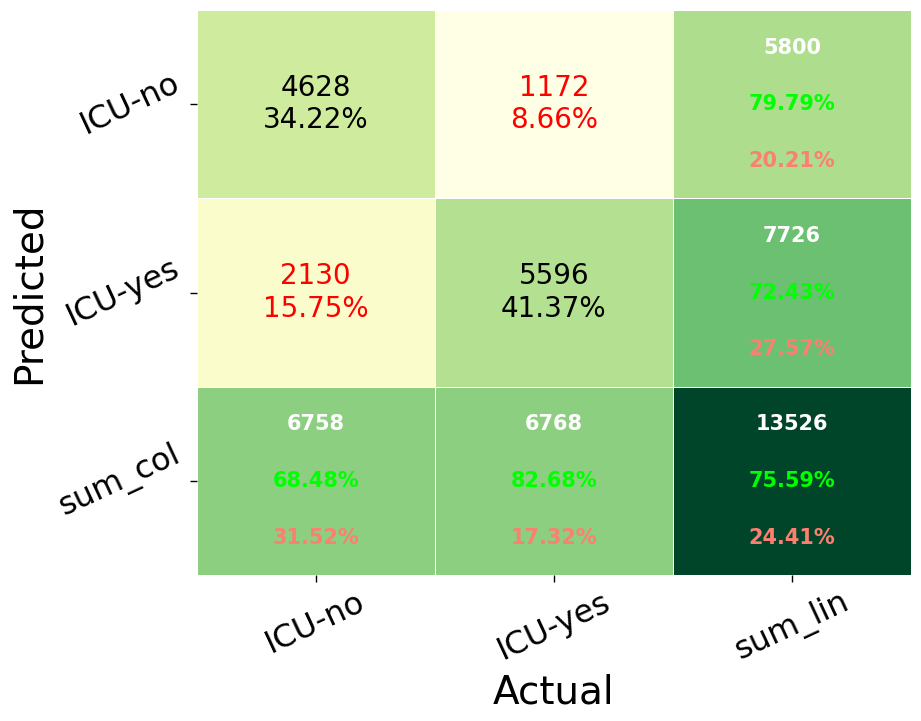

In [34]:
plot_confusion_matrix_from_data(y_test,
                                y_pred_lr,
                                columns=['ICU-no', 'ICU-yes'],
                                fz=20,
                                filename='ICU_LR_CM.eps',
                                figsize=[10, 8])

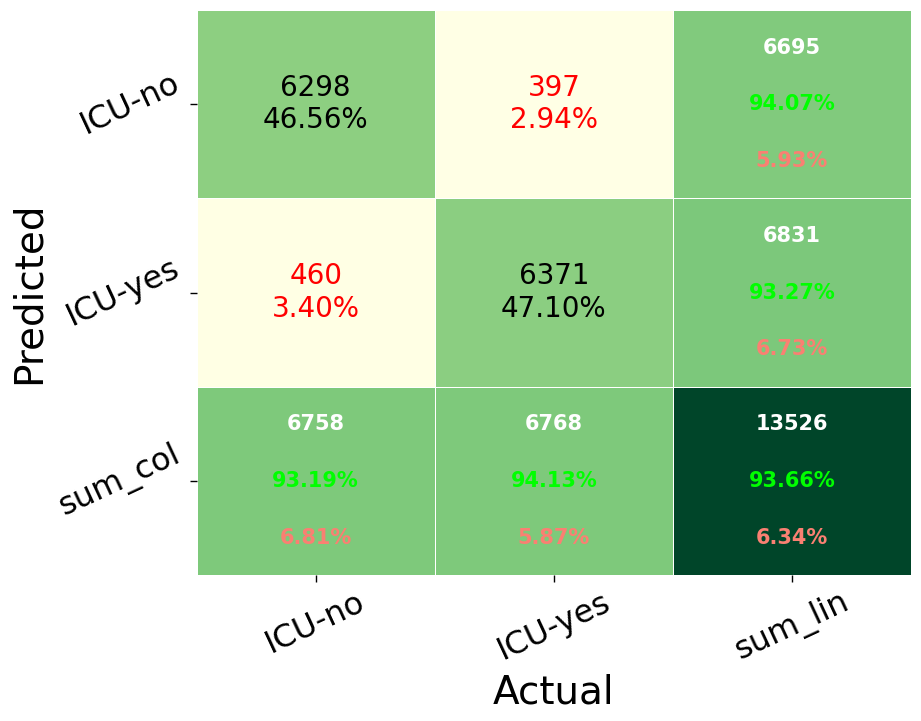

In [35]:
plot_confusion_matrix_from_data(y_test,
                                y_pred_lgbm,
                                columns=['ICU-no', 'ICU-yes'],
                                fz=20,
                                filename='ICU_LGBM_CM.eps',
                                figsize=[10, 8])

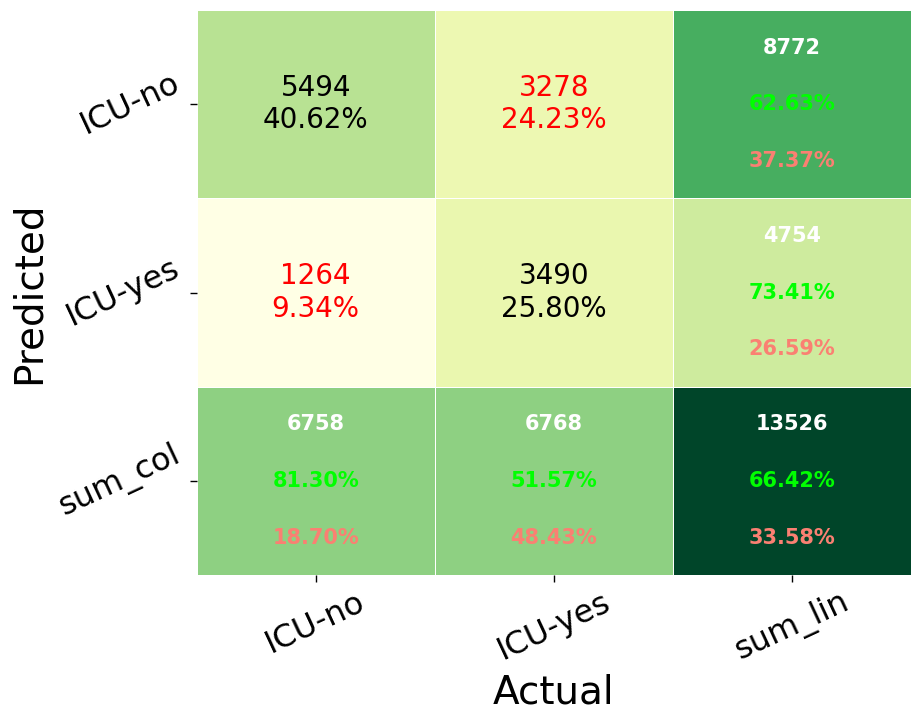

In [36]:
plot_confusion_matrix_from_data(y_test,
                                y_pred_gnb,
                                columns=['ICU-no', 'ICU-yes'],
                                fz=20,
                                filename='ICU_GNB_CM.eps',
                                figsize=[10, 8])

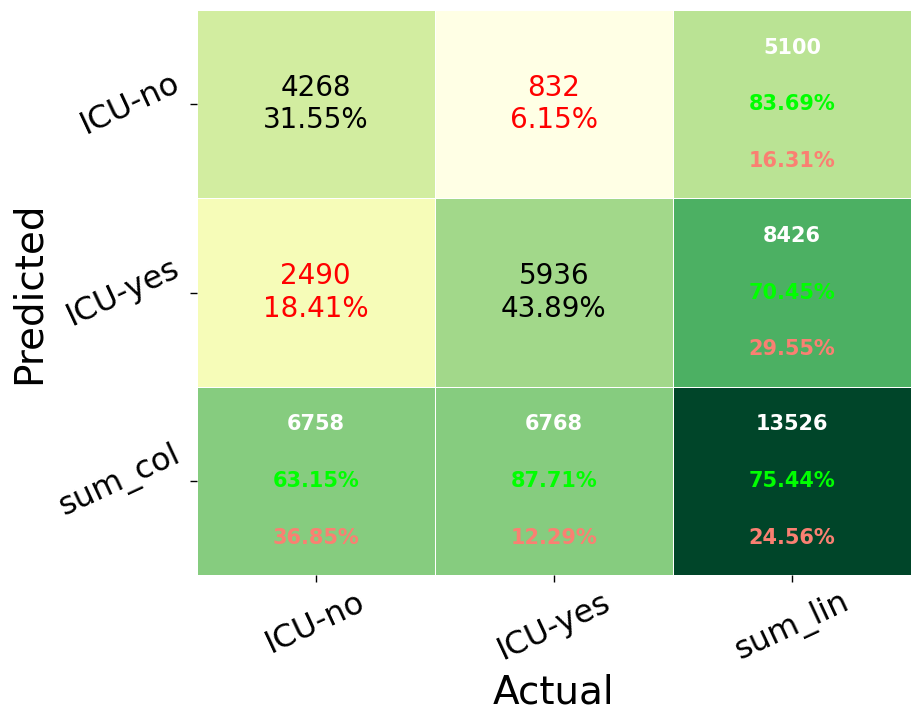

In [37]:
plot_confusion_matrix_from_data(y_test,
                                y_pred_lda,
                                columns=['ICU-no', 'ICU-yes'],
                                fz=20,
                                filename='ICU_LDA_CM.eps',
                                figsize=[10, 8])

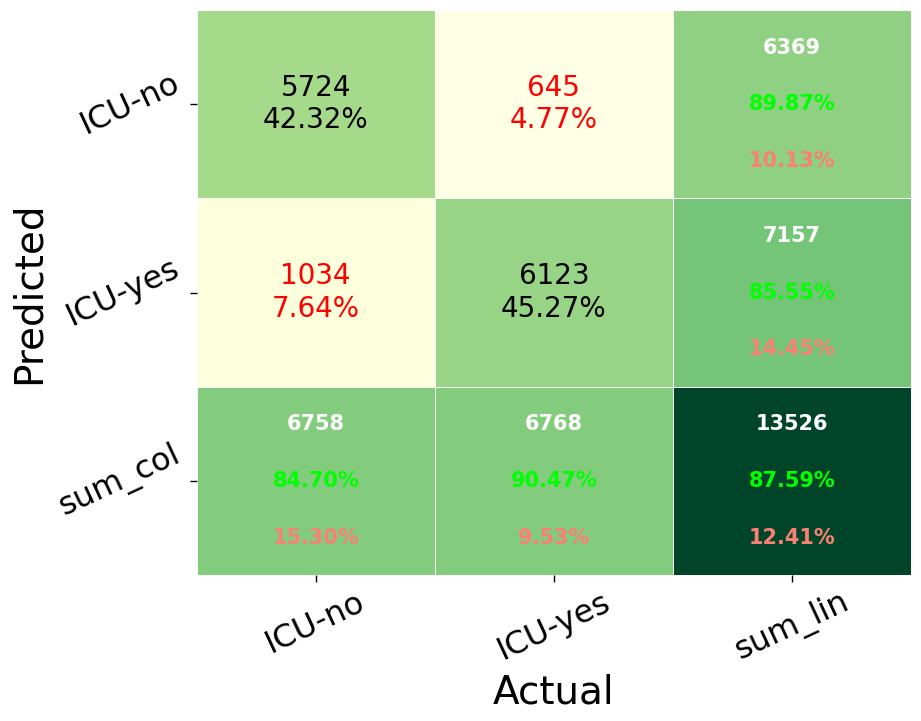

In [38]:
plot_confusion_matrix_from_data(y_test,
                                y_pred_knn,
                                columns=['ICU-no', 'ICU-yes'],
                                fz=20,
                                filename='ICU_KNN_CM.eps',
                                figsize=[10, 8])

In [40]:
from pycm import *

In [41]:
cm_HGSOXGB = ConfusionMatrix(
    actual_vector=np.array(y_test),
    predict_vector=np.array(y_pred_hgsoxgb))  # Create CM From Data

print(cm_HGSOXGB)

Predict    0          1          
Actual
0          6527       231        

1          122        6646       





Overall Statistics : 

95% CI                                                            (0.97122,0.97659)
ACC Macro                                                         0.9739
ARI                                                               0.89833
AUNP                                                              0.9739
AUNU                                                              0.9739
Bangdiwala B                                                      0.94855
Bennett S                                                         0.9478
CBA                                                               0.96611
CSI                                                               0.94793
Chi-Squared                                                       12153.99075
Chi-Squared DF                                                    1
Conditional Entropy                         

In [42]:
cm_GNB = ConfusionMatrix(
    actual_vector=np.array(y_test),
    predict_vector=np.array(y_pred_gnb))  # Create CM From Data

print(cm_GNB)

Predict    0          1          
Actual
0          5494       1264       

1          3278       3490       





Overall Statistics : 

95% CI                                                            (0.65624,0.67216)
ACC Macro                                                         0.6642
ARI                                                               0.10779
AUNP                                                              0.66431
AUNU                                                              0.66431
Bangdiwala B                                                      0.46322
Bennett S                                                         0.3284
CBA                                                               0.57099
CSI                                                               0.34453
Chi-Squared                                                       1602.09996
Chi-Squared DF                                                    1
Conditional Entropy                        

In [43]:
cm_lda = ConfusionMatrix(
    actual_vector=np.array(y_test),
    predict_vector=np.array(y_pred_lda))  # Create CM From Data

print(cm_GNB)

Predict    0          1          
Actual
0          5494       1264       

1          3278       3490       





Overall Statistics : 

95% CI                                                            (0.65624,0.67216)
ACC Macro                                                         0.6642
ARI                                                               0.10779
AUNP                                                              0.66431
AUNU                                                              0.66431
Bangdiwala B                                                      0.46322
Bennett S                                                         0.3284
CBA                                                               0.57099
CSI                                                               0.34453
Chi-Squared                                                       1602.09996
Chi-Squared DF                                                    1
Conditional Entropy                        

In [44]:
cm_y_pred_knn = ConfusionMatrix(
    actual_vector=np.array(y_test),
    predict_vector=np.array(y_pred_knn))  # Create CM From Data

print(cm_y_pred_knn)

Predict    0          1          
Actual
0          5724       1034       

1          645        6123       





Overall Statistics : 

95% CI                                                            (0.87031,0.88143)
ACC Macro                                                         0.87587
ARI                                                               0.56508
AUNP                                                              0.87585
AUNU                                                              0.87585
Bangdiwala B                                                      0.76798
Bennett S                                                         0.75174
CBA                                                               0.85126
CSI                                                               0.75297
Chi-Squared                                                       7668.82223
Chi-Squared DF                                                    1
Conditional Entropy                      

In [45]:
cm_y_pred_lgbm = ConfusionMatrix(
    actual_vector=np.array(y_test),
    predict_vector=np.array(y_pred_lgbm))  # Create CM From Data

print(cm_y_pred_lgbm)

Predict    0          1          
Actual
0          6298       460        

1          397        6371       





Overall Statistics : 

95% CI                                                            (0.93254,0.94075)
ACC Macro                                                         0.93664
ARI                                                               0.7626
AUNP                                                              0.93664
AUNU                                                              0.93664
Bangdiwala B                                                      0.87732
Bennett S                                                         0.87328
CBA                                                               0.9323
CSI                                                               0.87332
Chi-Squared                                                       10316.06917
Chi-Squared DF                                                    1
Conditional Entropy                       

In [46]:
cm_y_pred_gbc = ConfusionMatrix(
    actual_vector=np.array(y_test),
    predict_vector=np.array(y_pred_gbc))  # Create CM From Data

print(cm_y_pred_gbc)

Predict    0          1          
Actual
0          5066       1692       

1          680        6088       





Overall Statistics : 

95% CI                                                            (0.81823,0.83104)
ACC Macro                                                         0.82463
ARI                                                               0.42151
AUNP                                                              0.82458
AUNU                                                              0.82458
Bangdiwala B                                                      0.68565
Bennett S                                                         0.64927
CBA                                                               0.76607
CSI                                                               0.65667
Chi-Squared                                                       5831.7988
Chi-Squared DF                                                    1
Conditional Entropy                       

In [47]:
cm_y_y_pred_lr = ConfusionMatrix(
    actual_vector=np.array(y_test),
    predict_vector=np.array(y_pred_lr))  # Create CM From Data

print(cm_y_y_pred_lr)

Predict    0          1          
Actual
0          4628       2130       

1          1172       5596       





Overall Statistics : 

95% CI                                                            (0.74864,0.76312)
ACC Macro                                                         0.75588
ARI                                                               0.26184
AUNP                                                              0.75583
AUNU                                                              0.75583
Bangdiwala B                                                      0.57641
Bennett S                                                         0.51176
CBA                                                               0.70456
CSI                                                               0.51694
Chi-Squared                                                       3614.19371
Chi-Squared DF                                                    1
Conditional Entropy                      